# Python at EBC

This notebook contains several examples covering the issues from the tutorial.


## Usage of object orientation for Verwendung von Objektorientierung zur effizienten Auswertung
Object Orientation allows you to re-use your code easily. Especially if you are comparing things that create often similar types of data, using object orientation is of great adavantage. Getting the head around object orientation is a bit more complicated and needs some more work in the planing stage, but it is totally worth it.

In the next steps we present a base class to keep simulation or measurement data

### Creating a Base Class and use Inheritance

In [58]:
%matplotlib notebook
import os.path
import pandas as pd
import pylab as plt

class BaseData(object):
    ''' Keep simulation or measurement data
    
        Parameters
        -----------
        filename : str
            path to filename
            
        name : str, optional [None]
            It is always a good idea to label your data, if None, name will
            be determined from filename
        
        Attributes
        -----------
        data : pd.Series
            data read from result file, c
            
        savedir : str
            path were results/figures etc. should be saved, defaults to 'D:/'
    '''
    
    def __init__(self, filename, name=None):
        self.filename = filename
        self.savedir = 'D:/'
        self.data = self.read_data()
        #If no name is provided, the name will be created from the filename
        if name is None:
            _dummy = (os.path.basename(filename).split('.')[:-1]) # Get the filename without suffix
            self.name = ''.join(_dummy) # Rebuild a string from resulting list
        else:
            self.name = name
               
    def read_data(self):
        ''' Read data from input file
        
            Returns:
            ----------
            pd.DataFrame
        '''
        data = pd.Series.from_csv(self.filename, header=0)
        return data
    
    def plot_data(self, label=None, fig=None, ax=None):
        ''' Plot the data into a figure
        
            Parameters:
            ----------
            label : str, optional [self.name]
                Identifier for this function (used in the legend)
            fig : matplotlib.figure instance, optional [None]
                Figure to plot into, will be created if None
            ax : matplotlib.axes instance, optional [None]
                Axes to plot into, will be created if None
        
            Returns:
            ----------
            None
            
            Notes:
            ----------
            In the EBC-Python Library exist an advanced helper to create figures and axes
            (the first few lines in this code), see base_functions.reusable_helpers.helper_figures
        
        '''
        if fig is None and ax is None:
            fig, ax = plt.subplots()
        elif fig is None:
            fig = ax.get_figure()
        elif ax is None:
            ax = fig.add_axes()
        if label is None:
            label = self.name
        self.data.plot(ax=ax, label=label)
        ax.set_title('Power vs. travel' )
        ax.set_ylabel('Power in kW')
        ax.legend()
        
a = BaseData('Referenz.csv')
b = BaseData('Messung1.csv')


Directly below the class definition is the docstring, every method of the class also contains a docstring. The function \__init\__ is run when an instance of the class is created. Note that the data are read from the file on initialization, because the read_data() method is called.

There exist also a third method, plot_data, that does exactly what you would expect. The first six lines of the code make sure that you can use the method to plot into an already existing figure, or into a complete new figure.

If you now want to plot two measurements into one axes, this can be easily solved by creating one pair of axes and provide them as optional parameter to the plot function

<IPython.core.display.Javascript object>


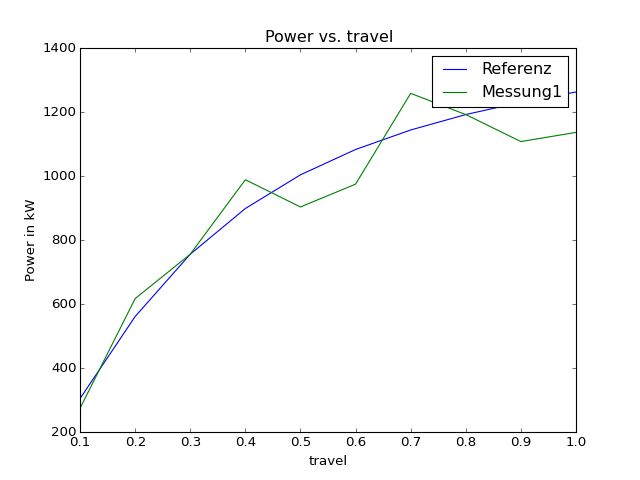

In [59]:
fig, ax = plt.subplots() # Create empty figure with on pair of axes
a.plot_data('Referenz',fig=fig, ax=ax)# Usage of optional parameters
b.plot_data(fig=fig, ax=ax) # If no label is provided, the class's .name attribute will be used

The code above allows reading different measurement results, as long as they are saved in the same way. But now imagine, while the measurements were ongoing, the saving format was changed, for example instead of saving csv-Files, now excel files are saved.

The data are the same, all methods could still be used, expect the reading function. Object Orientation now allows to inherit from an object and replace the `read_data` method by a customized version. Therefore below a new class is derived from the BaseData class. Every method is inherited from BaseData (including the `__item___` method). Only the `read_data` method is replaced.

<IPython.core.display.Javascript object>


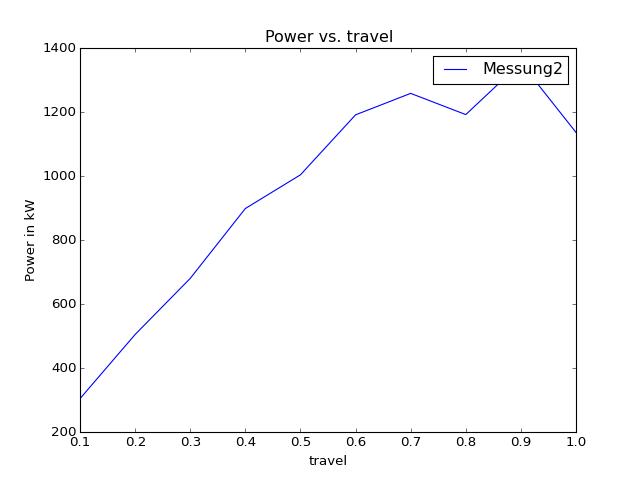

In [60]:
class NewData(BaseData):
    ''' Modified Version of BaseData, only reading Method is changed
    '''
          
    def read_data(self):
        ''' Read data from input file
        
            Returns:
            ----------
            pd.DataFrame
        '''
        data = pd.read_excel(self.filename, index_col = 0)
        data=data.iloc[:,0] # Transform pd.DataFrame to pd.Series
        return data
c = NewData('Messung2.xlsx')
c.plot_data()

Although the plot function is not explicitly listed, it also works for the new class.

It is now easy to keep your single measurements in one class. If you want to add additional analysis methods, add them to the class and every measurement can be analysed easily in the same way. 

A next step would be to compare different measurement results. For this another class is created, a comparison class that keeps your measurements and provides methods to compare them.

### Use a wrapping class to compare results

[<__main__.BaseData object at 0x000000000B86D4E0>, <__main__.BaseData object at 0x000000000B86DCC0>, <__main__.NewData object at 0x000000000B695CC0>]


<IPython.core.display.Javascript object>


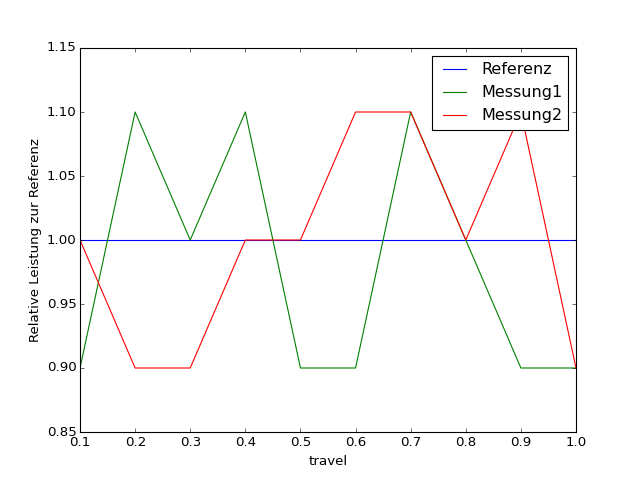

<IPython.core.display.Javascript object>


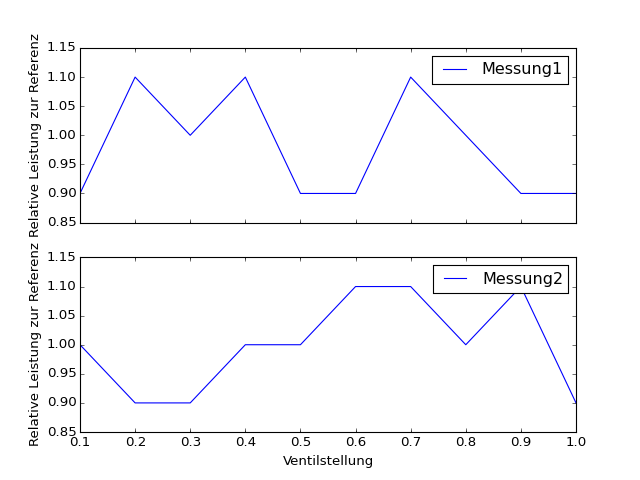

In [61]:
class Comparison(object):
    """ Compare results of the Measurements contained in BaseData and derived classes
    
        Parameters
        ----------
        None
        
        Attributes
        ----------
        members : list of BaseData instances (and derived), 
            if you add an result by the add_result method, it is added as an member to this list
            
        members_by_name : dict of BaseData instances
            also added by calling the add_result method, key will be the classes .name
            
        reference : BaseData instance
            a reference measurement (e.g. for scaling)
    """
    def __init__(self):
        self.members = [] # Keep a list of the added results (in contrast to the dictionary below, this will keep the order the data were added)
        self.members_by_name = {} # If you would like to access them by name directly
        self.reference = None
        
    def add_result(self, obj):
        """ Add results of one the measurement the attribute `members`.

        Parameters:
        ----------
        obj : Instance of BaseData (or inherited)

        Returns:
        ----------
        None

        """
        # make sure it is the appropriate format
        assert isinstance(obj, BaseData), 'Obj must be an instance of BaseData, but got {0}'.format(type(obj))
        # don't add two measurements with the same name
        assert obj.name not in list(self.members_by_name.keys()), 'Measurement with name {0} already exists'.format(obj.name)
        self.members.append(obj)
        self.members_by_name[obj.name] = obj
        
    def set_reference(self, obj):
        """ Define an reference value
        
        Parameters
        ----------
        obj : Instance of BaseData(or inherited)
        
        """
        assert isinstance(obj, BaseData), 'Obj must be an instance of BaseData, but got {0}'.format(type(obj))
        self.reference = obj
        
        
    def plot_relative(self, result, fig, ax):
        ''' Plot the measured data relative to the reference data
        
            Parameters:
            ----------
            result : BaseData object
                The result that should be plotted
                
            fig : matplotlib.figure instance
                Figure to plot into, will be created if None
                
            ax : matplotlib.axes instance
                Axes to plot into, will be created if None
        '''
        rel = result.data / self.reference.data
        rel.plot(ax=ax, label = result.name)
        ax.set_ylabel('Relative Leistung zur Referenz')
        ax.legend()

# Daten zur Klasse hinzufügen
all_results = Comparison()
all_results.add_result(a)
# all_results.add_result(a) # Adding this a second time is prevented by the assert statement, uncomment to test
all_results.add_result(b)
all_results.add_result(c)
all_results.set_reference(all_results.members_by_name['Referenz'])
print(all_results.members)

# Alle Ergebnisse in einen Plot
fig, ax = plt.subplots()
for member in all_results.members:
    all_results.plot_relative(member, fig, ax)
    
# Alternativ als Plot nebeneinander
fig, ax = plt.subplots(2, sharex=True)
for i, member in enumerate(all.members[1:]):
    all_results.plot_relative(member, fig, ax[i])
ax[0].set_xlabel('') # Doppeltes Label an der X-Achse entfernen

A comparison class is usefull because all measurements can easily be accessed. Adding and deleting results is easily possible (although an explicit delete method should be created so that .members and .members_by_name are always the same).

### Possible improvements
Python provides several [magic members](http://rafekettler.com/magicmethods.html), which can be usefull to improve your code. To keep an overview of your results using the `__str__` method is suggested.

In [62]:
class AdvancedBaseData(BaseData):
    def __str__(self):
        return 'Class {0}, named {1} from file {2}'.format(type(self), self.name, os.path.abspath(self.filename))
        
d = AdvancedBaseData('Messung1.csv')
print(d)


Class <class '__main__.AdvancedBaseData'>, named Messung1 from file D:\GIT\EBC-Tutorials\EBC-Python-101\Messung1.csv


Also the Comparison class can be further enhanced by using some magic members. Allowing to iterate over the different simulations or a direct access to one result can be added by the magic members. At this moment,the next three statements will fail (uncomment them, to test):

In [63]:
#for result in all_results:
#    print(result)
    
#all_results[1]

len(all_results)

TypeError: object of type 'Comparison' has no len()

Adding some magic members will solve this problem

<IPython.core.display.Javascript object>


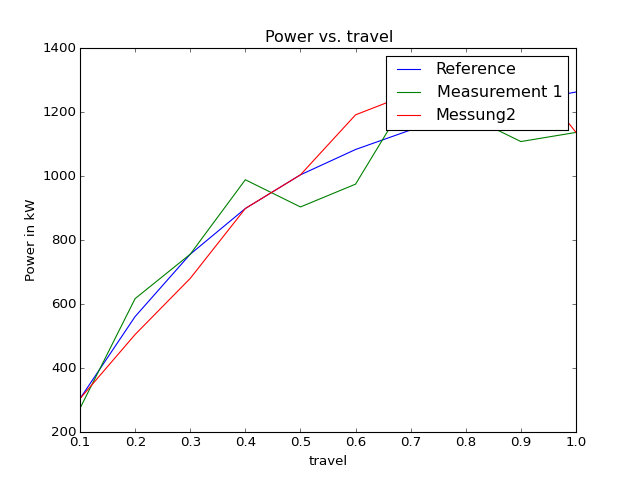

Zweites Element im Vergleichsobjekt: Class <class '__main__.AdvancedBaseData'>, named Measurement 1 from file D:\GIT\EBC-Tutorials\EBC-Python-101\Messung1.csv


3

In [64]:
class AdvancedComparison(Comparison):
    def __len__(self):
        return len(self.members)
    
    def __iter__(self):
        for item in self.members:
            yield(item)
            
    def __getitem__(self, i):
        return self.members[i]
    
ac = AdvancedComparison()
ac.add_result(AdvancedBaseData('Referenz.csv', 'Reference'))
ac.add_result(AdvancedBaseData('Messung1.csv', 'Measurement 1'))
ac.add_result(c)
fig, ax = plt.subplots()
for result in ac:
    result.plot_data(ax=ax)
    
print('Zweites Element im Vergleichsobjekt: ' + str(ac[1]))

len(ac)

### Some remarks
- If you ask yourself, if a method should be stored in a Comparison Class or class that just keeps your data, we suggest the following rule of thumb: If the method can be self-contained  in its data class, keep it there (e.g. the `plot_data` method), combining them to a comparing plot is easily done (see usage of the iteration through the `__iter__` method above). If it contains already some comparison, for example the plot relative to a reference, put it into your Comparison class

- We used assert statements to make sure that only allowed classes are added to the comparison class. Some people would oppose this method and suggest you use [duck typing](https://en.wikipedia.org/wiki/Duck_typing). Either way you go, it will result in an Error sooner or later if you add the wrong data